<a href="https://colab.research.google.com/github/Everysimo/DarkPattern_Thesis/blob/main/DarkPattern_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione Dark Pattern

## Ottenimento del dataset

In [135]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from six.moves import urllib
from matplotlib import style
import missingno as msno
import pickle
import imblearn

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/Everysimo/DarkPattern_Thesis/main/dark-patterns-v2.csv"

#fetch del dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["Pattern String", "Comment", "Pattern Category", "Pattern Type", "Where in website?", "Deceptive?", "Website Page"]]
df.head(5)

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
0,Collin P. from Grandview Missouri just bought ...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://alaindupetit.com/collections/all-suits...
1,"Faith in Glendale, United States purchased a C...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bonescoffee.com/products/strawberry-ch...
2,Sharmeen Atif From Karachi just bought Stylish...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://brandsego.com/collections/under-rs-99/...
3,9 people are viewing this.,Product detail,Social Proof,Activity Notification,Product Page,No,https://brightechshop.com/products/ambience-so...
4,5338 people viewed this in the last hour,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bumpboxes.com/


## 1) Data Cleaning

### 1.1) Descrizione del dataset

In [136]:
#descrizione del dataset
df.describe()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
count,1515,1798,1818,1818,1818,1818,1818
unique,1181,371,7,15,5,3,1398
top,Only 1 left,Product detail,Scarcity,Low-stock Message,Product Page,No,https://fuzz.online/products/fg-grater
freq,26,684,679,632,1609,1584,11


### 1.2) Verifica valori null nel dataset

In [137]:
#verifica se ci sono dati null nel dataset
df.isnull().any()
df.isnull().sum()

Pattern String       303
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

In [138]:
#verifica se ci sono dati NA nel dataset
print(df.isna().any())
df.isna().sum()

Pattern String        True
Comment               True
Pattern Category     False
Pattern Type         False
Where in website?    False
Deceptive?           False
Website Page         False
dtype: bool


Pattern String       303
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

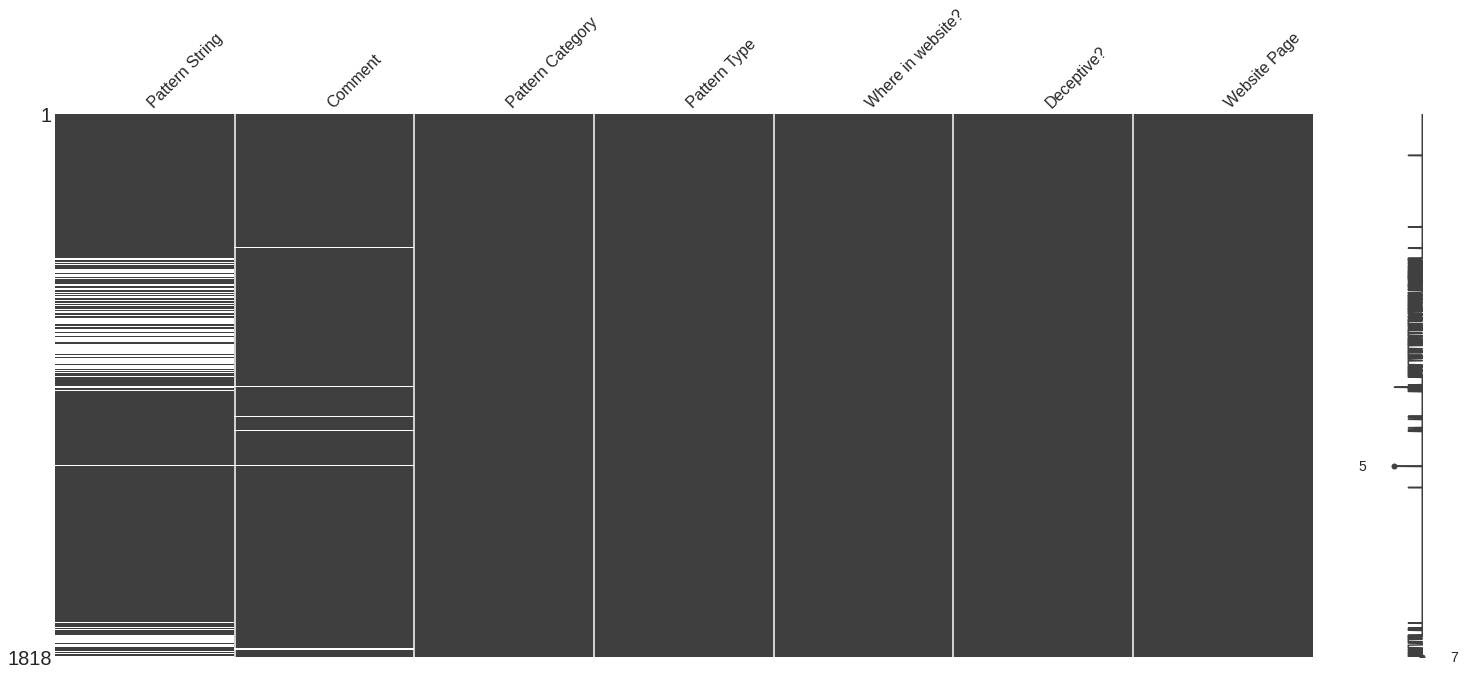

In [139]:
%matplotlib inline
msno.matrix(df)

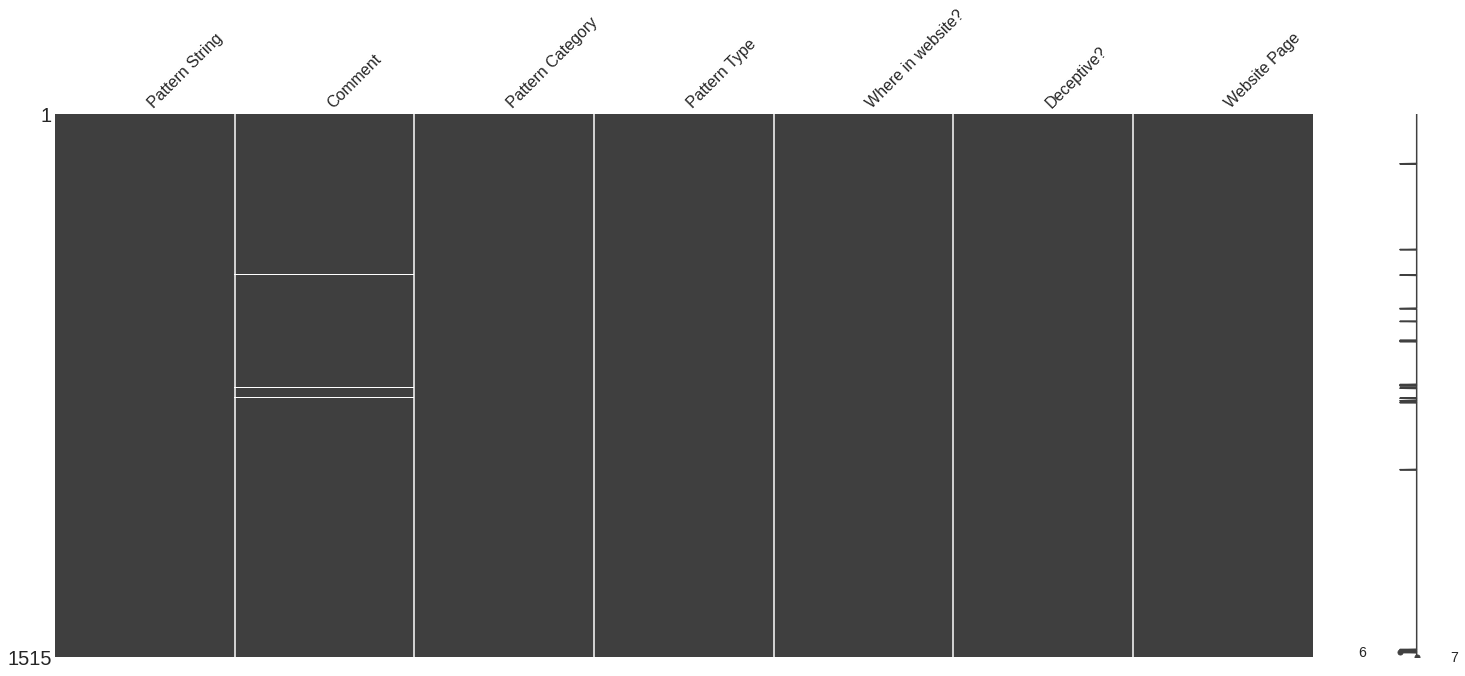

In [140]:
df = df.dropna(subset=['Pattern String'])
%matplotlib inline
msno.matrix(df)

### 1.3) Feature Selection

In [141]:
df=df[["Pattern String", "Pattern Type"]]
df.head(5)

,Pattern String,Pattern Type
0,Collin P. from Grandview Missouri just bought ...,Activity Notification
1,"Faith in Glendale, United States purchased a C...",Activity Notification
2,Sharmeen Atif From Karachi just bought Stylish...,Activity Notification
3,9 people are viewing this.,Activity Notification
4,5338 people viewed this in the last hour,Activity Notification


## 2)Text Pre-Processing

In [148]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")

df['Pattern String'] = df['Pattern String'].fillna('').apply(str)
df['Pattern String'] = df['Pattern String'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

vectorizer = TfidfVectorizer(min_df= 3,stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

tfidf_transformer = TfidfTransformer()

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Pattern String,Pattern Type
0,collin p grandview missouri bought burgundi tw...,Activity Notification
1,faith glendal unit state purcha choo flavor ba...,Activity Notification
2,sharmeen atif karachi bought stylish metal gla...,Activity Notification
3,peopl view,Activity Notification
4,peopl view last hour,Activity Notification
...,...,...
1810,two free pillow promo code,Visual Interference
1812,compar,Visual Interference
1813,,Visual Interference
1814,thi offer valid add cart,Visual Interference


##3)Creazione Modelli

### RandomForestClassifier

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time:  0.31843387285868324
Accuracy:  0.9469425345895935
F1_micro:  0.9469425345895935
Precision_micro:  0.9469425345895935
Recall_micro:  0.9469425345895935


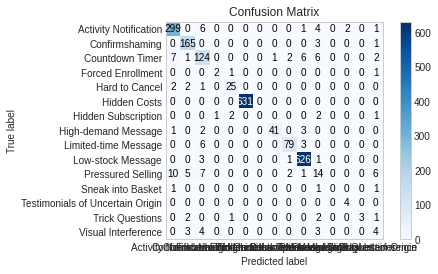

<Figure size 7200x7200 with 0 Axes>

In [143]:
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold, KFold,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plot
import numpy as num
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.model_selection import cross_val_predict


import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

ros = RandomOverSampler(sampling_strategy='minority')
X, y = ros.fit_resample(X,y)

#Usiamo una Pipeline per automatizzare i vari setp
steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('clf', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10,random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
scores = cross_validate(pipeline, X.flatten(), y, scoring=scoring, cv=cv)
print(scores.keys())
print("fit_time: ",np.mean(scores['fit_time']))
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

predictions = cross_val_predict(pipeline, X.flatten(), y,cv=StratifiedKFold(n_splits=3))

X = vectorizer.fit_transform(X.flatten())

skplt.metrics.plot_confusion_matrix(y, predictions)
plt.figure(figsize=(100,100))
plt.show()


### Multinomial Naive Bayes

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time:  0.036037166913350425
Accuracy:  0.9338334214804802
F1_micro:  0.9338334214804802
Precision_micro:  0.9338334214804802
Recall_micro:  0.9338334214804802


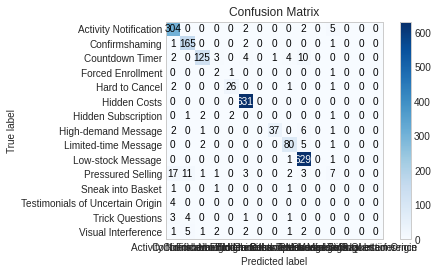

In [144]:
from sklearn.naive_bayes import MultinomialNB

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

ros = RandomOverSampler(sampling_strategy='minority')
X, y = ros.fit_resample(X,y)

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('clf', MultinomialNB())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10,random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X.flatten(), y, scoring=scoring, cv=cv)
print(scores.keys())
print("fit_time: ",np.mean(scores['fit_time']))
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

predictions = cross_val_predict(pipeline, X.flatten(), y,cv=StratifiedKFold(n_splits=3))

X = vectorizer.fit_transform(X.flatten())

skplt.metrics.plot_confusion_matrix(y, predictions)
plt.show()

### KNeighborsClassifier

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time:  0.03248252868652344
Accuracy:  0.8789415812945226
F1_micro:  0.8789415812945226
Precision_micro:  0.8789415812945226
Recall_micro:  0.8789415812945226


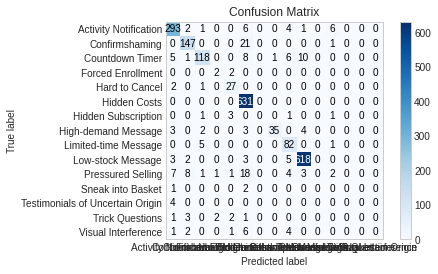

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler


#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

ros = RandomOverSampler(sampling_strategy='minority')
X, y = ros.fit_resample(X,y)

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('clf', KNeighborsClassifier(n_neighbors=43))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10,random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X.flatten(), y, scoring=scoring, cv=cv)
print(scores.keys())
print("fit_time: ",np.mean(scores['fit_time']))
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

predictions = cross_val_predict(pipeline, X.flatten(), y,cv=StratifiedKFold(n_splits=3))

X = vectorizer.fit_transform(X.flatten())

skplt.metrics.plot_confusion_matrix(y, predictions)
plt.show()

### LinearSVC

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time:  0.07954580307006837
Accuracy:  0.9471950141361907
F1_micro:  0.9471950141361907
Precision_micro:  0.9471950141361907
Recall_micro:  0.9471950141361907


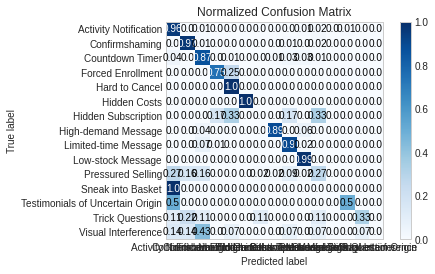

In [146]:
from sklearn.svm import LinearSVC

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

ros = RandomOverSampler(sampling_strategy='minority')
X, y = ros.fit_resample(X,y)

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('clf', LinearSVC())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=50,random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X.flatten(), y, scoring=scoring, cv=cv)
print(scores.keys())
print("fit_time: ",np.mean(scores['fit_time']))
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

predictions = cross_val_predict(pipeline, X.flatten(), y,cv=StratifiedKFold(n_splits=3))

X = vectorizer.fit_transform(X.flatten())

skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

### Voting Classifier

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time:  0.40660843849182127
Accuracy:  0.9466635978400684
F1_micro:  0.9466635978400684
Precision_micro:  0.9466635978400684
Recall_micro:  0.9466635978400684


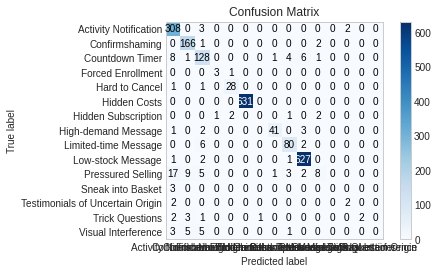

In [147]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

ros = RandomOverSampler(sampling_strategy='minority')
X, y = ros.fit_resample(X,y)

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('clf', VotingClassifier(estimators=[('rfc',RandomForestClassifier()),
                                    ('mnb',MultinomialNB()),
                                    ('svc',LinearSVC())],
                        voting="hard"))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10,random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X.flatten(), y, scoring=scoring, cv=cv)
print(scores.keys())
print("fit_time: ",np.mean(scores['fit_time']))
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

predictions = cross_val_predict(pipeline, X.flatten(), y,cv=StratifiedKFold(n_splits=3))

X = vectorizer.fit_transform(X.flatten())

skplt.metrics.plot_confusion_matrix(y, predictions)
plt.show()